<a href="https://colab.research.google.com/github/terrence-ou/DL_Playground/blob/main/%5BHC%5DAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple AutoEncoder and Latent Space Visualization with PyTorch

## Preliminaries

In [ ]:
import os
import random
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import torchvision
from torchvision import transforms

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Project running on device: ", DEVICE)

Project running on device:  cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/mni.zip

Archive:  /content/drive/MyDrive/mni.zip
 extracting: mni/MNI_AD1.nii         
 extracting: mni/MNI_AD10.nii        
 extracting: mni/MNI_AD11.nii        
 extracting: mni/MNI_AD12.nii        
 extracting: mni/MNI_AD13.nii        
 extracting: mni/MNI_AD14.nii        
 extracting: mni/MNI_AD15.nii        
 extracting: mni/MNI_AD16.nii        
 extracting: mni/MNI_AD17.nii        
 extracting: mni/MNI_AD18.nii        
 extracting: mni/MNI_AD19.nii        
 extracting: mni/MNI_AD2.nii         
 extracting: mni/MNI_AD20.nii        
 extracting: mni/MNI_AD21.nii        
 extracting: mni/MNI_AD22.nii        
 extracting: mni/MNI_AD23.nii        
 extracting: mni/MNI_AD24.nii        
 extracting: mni/MNI_AD25.nii        
 extracting: mni/MNI_AD26.nii        
 extracting: mni/MNI_AD27.nii        
 extracting: mni/MNI_AD28.nii        
 extracting: mni/MNI_AD29.nii        
 extracting: mni/MNI_AD3.nii         
 extracting: mni/MNI_AD30.nii        
 extracting: mni/MNI_AD31.nii        
 extracti

Processing file 1
91


KeyboardInterrupt: 

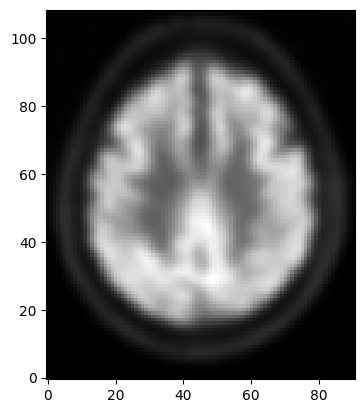

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def convert_nii_to_png(input_folder, output_folder):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all files in the input folder
    count = 1
    for filename in os.listdir(input_folder):
        if filename.endswith(".nii") or filename.endswith(".nii.gz"):
            # Load the NIfTI file
            print(f"Processing file {count}")
            count += 1
            nii_path = os.path.join(input_folder, filename)
            nii_image = nib.load(nii_path)
            nii_data = nii_image.get_fdata()

            # Assuming we want to convert all slices along the z-axis
            num_slices = nii_data.shape[2]
            print(num_slices)
            for i in range(num_slices):
                # Extract the i-th slice
                # print(f"slice {i}")
                slice_data = nii_data[:, :, i]
                plt.imshow(slice_data.T, cmap='gray', origin='lower')
                output_filename = f"{os.path.splitext(filename)[0]}_slice_{i + 1}.png"
                output_path = os.path.join(output_folder, output_filename)
                plt.savefig(output_path)
                #plt.show()
                # Normalize the slice data to [0, 255] for PNG format
                #slice_data = np.rot90(slice_data)  # Rotate for better viewing
                #slice_data = (255 * (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))).astype(np.uint8)

                # Save the slice as a PNG file

                #plt.imsave(output_path, slice_data, cmap="gray")
    print("Conversion completed!")

# Example usage
input_folder = "mni"
output_folder = "images_of_brain"
convert_nii_to_png(input_folder, output_folder)

In [ ]:
!pip install nibabel

## Loading dataset of Brain Images

In [ ]:
config = {
    "batch_size": 32,
    "epochs": 50,
    "lr": 1e-4,
}

labels = ["AD", "CN", "MCI", "EMCI", "LMCI"]

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

def collate_fn(batch):
    process = transforms.Compose([
              transforms.Resize((128, 128)),
              transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))
              ])

    x = [process(data[0]) for data in batch]
    x = torch.concat(x).unsqueeze(1)
    # x = x.unsqueeze(0)

    y = torch.LongTensor([data[1] for data in batch])

    return x, y

data_dir = "/content/drive/MyDrive/images_of_brain"
val_split = 0.2

# Get all image file paths
all_image_paths = []

for file in os.listdir(data_dir):
    if file.endswith(".png"):
        try:
            image = Image.open(os.path.join(data_dir, file))
            if image.mode != "L":
                image = image.convert("L")
            image_array = np.array(image)
            total_pixels = image_array.size
            black_pixels = np.sum(image_array == 0)
            black_pixel_percentage = (black_pixels / total_pixels) * 100
            if black_pixel_percentage >= 30:
                continue
            if "AD" in file:
                all_image_paths.append((image,0))
            elif "CN" in file:
                all_image_paths.append((image,1))
            elif "MCI" in file:
                all_image_paths.append((image,2))
            elif "EMCI" in file:
                all_image_paths.append((image,3))
            elif "LMCI" in file:
                all_image_paths.append((image,4))
            else:
              pass
        except:
            pass

# Split data into training and validation sets
train_dataset, val_dataset = train_test_split(all_image_paths, test_size=val_split, random_state=42)

print(train_dataset[0])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)

# Print the sizes of the datasets
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(valid_loader.dataset)}")


(<PIL.Image.Image image mode=L size=640x480 at 0x797161F4F340>, 2)
Number of training samples: 11392
Number of validation samples: 2849


Inspecting train data: 
Batch shape:  torch.Size([32, 1, 128, 128])


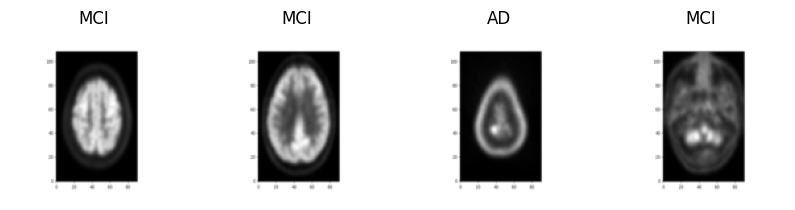

In [ ]:
print("Inspecting train data: ")
for _, data in enumerate(train_loader):
    print("Batch shape: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))
    for i in range(4):
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(labels[data[1][i]])
    plt.show()
    break

## AutoEncoder

Here we implement a mirrored encoder-decoder model

In [ ]:
INPUT_SHAPE = (128, 128)
LAYERS = 4
KERNELS = [3, 3, 3, 3]
CHANNELS = [32, 64, 128, 256]
STRIDES = [2, 2, 2, 2]

### Encoder

In [ ]:
import torch.nn as nn
import torch

class Encoder(nn.Module):
    def __init__(self, output_dim=2, use_batchnorm=False, use_dropout=False):
        super(Encoder, self).__init__()

        self.output_dim = output_dim

        self.layers = LAYERS
        self.channels = CHANNELS
        self.kernels = KERNELS
        self.strides = STRIDES
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout

        # Create convolutional layers dynamically
        self.conv_layers = self._create_conv_layers()

        # Calculate the flattened feature size
        self.flattened_features = self._calculate_flattened_features(INPUT_SHAPE)
        print(self.flattened_features)
        # Define a fully connected layer based on flattened features
        self.fc = nn.Linear(self.flattened_features, self.output_dim)  # Example output size is 128; adjust as needed

    def _create_conv_layers(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            # The input channel of the first layer is 1
            if i == 0: conv_layers.append(nn.Conv2d(1,
                                              self.channels[i],
                                              kernel_size=self.kernels[i],
                                              stride=self.strides[i],
                                              padding=1))

            else: conv_layers.append(nn.Conv2d(self.channels[i-1],
                                         self.channels[i],
                                         kernel_size=self.kernels[i],
                                         stride=self.strides[i],
                                         padding=1))

            if self.use_batchnorm:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.GELU())  # Use GELU as the activation function

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers

    def _calculate_flattened_features(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, 1, *input_shape)  # Create a dummy input with batch size 1
            x = self.conv_layers(x)

            return x.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

# Get the summary of autoencoder architecture
encoder = Encoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
summary(encoder, (1, INPUT_SHAPE[0], INPUT_SHAPE[1]))
pass


16384
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              GELU-3           [-1, 32, 64, 64]               0
         Dropout2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              GELU-7           [-1, 64, 32, 32]               0
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             GELU-11          [-1, 128, 16, 16]               0
        Dropout2d-12          [-1, 128, 16, 16]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
      BatchNorm2d-14            [

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):
        super(Decoder, self).__init__()

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = encoder.flattened_features
        self.input_dim = input_dim

        # Conv layer hypyer parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1] # flip the channel dimensions
        self.strides = STRIDES

        # In decoder, we first do fc project, then conv layers
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv =  self.get_convs()

        self.output = nn.Conv2d(self.channels[-1], 1, kernel_size=1, stride=1)


    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):

            if i == 0: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1)
                            )

            else: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i-1],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1
                                              )
                            )

            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.GELU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers

    def forward(self, x):
        x = self.linear(x)
        # reshape 3D tensor to 4D tensor
        shape = int((self.fc_dim /  self.channels[0])**0.5)
        x = x.reshape(x.shape[0], self.channels[0], shape, shape)
        x = self.conv(x)
        return self.output(x)

decoder = Decoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
summary(decoder, (1, 2))
pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 16384]          49,152
   ConvTranspose2d-2          [-1, 256, 16, 16]         590,080
       BatchNorm2d-3          [-1, 256, 16, 16]             512
              GELU-4          [-1, 256, 16, 16]               0
         Dropout2d-5          [-1, 256, 16, 16]               0
   ConvTranspose2d-6          [-1, 128, 32, 32]         295,040
       BatchNorm2d-7          [-1, 128, 32, 32]             256
              GELU-8          [-1, 128, 32, 32]               0
         Dropout2d-9          [-1, 128, 32, 32]               0
  ConvTranspose2d-10           [-1, 64, 64, 64]          73,792
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             GELU-12           [-1, 64, 64, 64]               0
        Dropout2d-13           [-1, 64, 64, 64]               0
  ConvTranspose2d-14         [-1, 32, 1

### AutoEncoder

In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(output_dim=2, use_batchnorm=True, use_dropout=False)
        self.decoder = Decoder(input_dim=2, use_batchnorm=True, use_dropout=False)

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = AutoEncoder().to(DEVICE)
summary(model, (1, INPUT_SHAPE[0], INPUT_SHAPE[1]))
pass

16384
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              GELU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              GELU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              GELU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             GELU-12            [-1, 256, 8, 8]               0
           Linear-13                    [-1, 2]          32,770
          Encoder-14             

## Experiment

In [ ]:
def plotting(step:int=0, show=False):

    model.eval() # Switch the model to evaluation mode

    points = []
    label_idcs = []

    path = "./ScatterPlots"
    if not os.path.exists(path): os.mkdir(path)

    for i, data in enumerate(valid_loader):
        img, label = [d.to(DEVICE) for d in data]
        # We only need to encode the validation images
        proj = model.encoder(img)
        points.extend(proj.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        del img, label

    points = np.array(points)

    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0,
                c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if show:
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else:
        # Do not show but only save the plot in training
        plt.savefig(f"{path}/Step_{step:03d}.png", bbox_inches="tight")
        plt.close() # don't forget to close the plot, or it is always in memory
        model.train()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-5)

# For mixed precision training
scaler = torch.cuda.amp.GradScaler()
steps = 0 # tracking the training steps

In [ ]:
def train(model, dataloader, criterion, optimizer, save_distrib=False):
    # steps is used to track training progress, purely for latent space plots
    global steps

    model.train()
    train_loss = 0.0

    # Process tqdm bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Train")


    for i, batch in enumerate(dataloader):

        optimizer.zero_grad()
        x = batch[0].to(DEVICE)

        # Here we implement the mixed precision training
        with torch.cuda.amp.autocast():
            y_recons = model(x)
            loss = criterion(y_recons, x)

        train_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_bar.set_postfix(
            loss=f"{train_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )

        # Saving latent space plots
        if steps % 10 == 0 and save_distrib and steps <= 400: plotting(steps)


        batch_bar.update()
        steps += 1

        torch.cuda.empty_cache()
        del x, y_recons

    batch_bar.close()
    train_loss /= len(dataloader)

    return train_loss

In [ ]:
def validate(model, dataloader, criterion):

    model.eval()
    valid_loss = 0.0

    # Progress tqdm bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Validation")

    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)

        with torch.no_grad():
            y_recons = model(x)
            loss = criterion(y_recons, x)

        valid_loss += loss.item()

        batch_bar.set_postfix(
            loss=f"{valid_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()

        torch.cuda.empty_cache()
        del x, y_recons

    batch_bar.close()
    valid_loss /= len(dataloader)

    return valid_loss

In [ ]:
# Train the model
for i in range(config["epochs"]):
    curr_lr = float(optimizer.param_groups[0]["lr"])
    train_loss = train(model, train_loader, criterion, optimizer, save_distrib=False) # Turn save_distrib = True if you wish animated latent space
    valid_loss = validate(model, valid_loader, criterion)
    print(f"Epoch {i+1}/{config['epochs']}\nTrain loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1/50
Train loss: 0.1118	 Validation loss: 0.0169	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 2/50
Train loss: 0.0140	 Validation loss: 0.0127	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 3/50
Train loss: 0.0114	 Validation loss: 0.0102	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 4/50
Train loss: 0.0102	 Validation loss: 0.0094	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 5/50
Train loss: 0.0096	 Validation loss: 0.0089	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 6/50
Train loss: 0.0090	 Validation loss: 0.0085	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 7/50
Train loss: 0.0086	 Validation loss: 0.0082	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 8/50
Train loss: 0.0084	 Validation loss: 0.0080	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 9/50
Train loss: 0.0082	 Validation loss: 0.0080	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10/50
Train loss: 0.0080	 Validation loss: 0.0080	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11/50
Train loss: 0.0079	 Validation loss: 0.0077	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12/50
Train loss: 0.0077	 Validation loss: 0.0076	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13/50
Train loss: 0.0078	 Validation loss: 0.0075	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14/50
Train loss: 0.0075	 Validation loss: 0.0073	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15/50
Train loss: 0.0074	 Validation loss: 0.0074	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 16/50
Train loss: 0.0075	 Validation loss: 0.0073	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 17/50
Train loss: 0.0073	 Validation loss: 0.0078	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 18/50
Train loss: 0.0073	 Validation loss: 0.0072	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 19/50
Train loss: 0.0072	 Validation loss: 0.0072	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 20/50
Train loss: 0.0072	 Validation loss: 0.0073	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 21/50
Train loss: 0.0070	 Validation loss: 0.0071	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 22/50
Train loss: 0.0071	 Validation loss: 0.0070	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 23/50
Train loss: 0.0071	 Validation loss: 0.0070	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 24/50
Train loss: 0.0069	 Validation loss: 0.0072	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 25/50
Train loss: 0.0069	 Validation loss: 0.0069	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 26/50
Train loss: 0.0069	 Validation loss: 0.0070	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 27/50
Train loss: 0.0069	 Validation loss: 0.0068	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 28/50
Train loss: 0.0068	 Validation loss: 0.0069	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 29/50
Train loss: 0.0067	 Validation loss: 0.0070	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 30/50
Train loss: 0.0068	 Validation loss: 0.0069	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 31/50
Train loss: 0.0068	 Validation loss: 0.0067	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 32/50
Train loss: 0.0067	 Validation loss: 0.0070	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 33/50
Train loss: 0.0067	 Validation loss: 0.0067	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 34/50
Train loss: 0.0067	 Validation loss: 0.0068	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 35/50
Train loss: 0.0066	 Validation loss: 0.0068	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 36/50
Train loss: 0.0066	 Validation loss: 0.0070	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 37/50
Train loss: 0.0066	 Validation loss: 0.0069	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 38/50
Train loss: 0.0066	 Validation loss: 0.0068	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 39/50
Train loss: 0.0066	 Validation loss: 0.0067	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 40/50
Train loss: 0.0066	 Validation loss: 0.0067	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 41/50
Train loss: 0.0065	 Validation loss: 0.0066	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 42/50
Train loss: 0.0066	 Validation loss: 0.0067	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 43/50
Train loss: 0.0065	 Validation loss: 0.0066	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 44/50
Train loss: 0.0065	 Validation loss: 0.0071	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 45/50
Train loss: 0.0064	 Validation loss: 0.0067	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 46/50
Train loss: 0.0064	 Validation loss: 0.0066	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 47/50
Train loss: 0.0064	 Validation loss: 0.0067	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 48/50
Train loss: 0.0064	 Validation loss: 0.0067	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 49/50
Train loss: 0.0063	 Validation loss: 0.0066	lr: 0.0001


Train:   0%|          | 0/356 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 50/50
Train loss: 0.0063	 Validation loss: 0.0067	lr: 0.0001


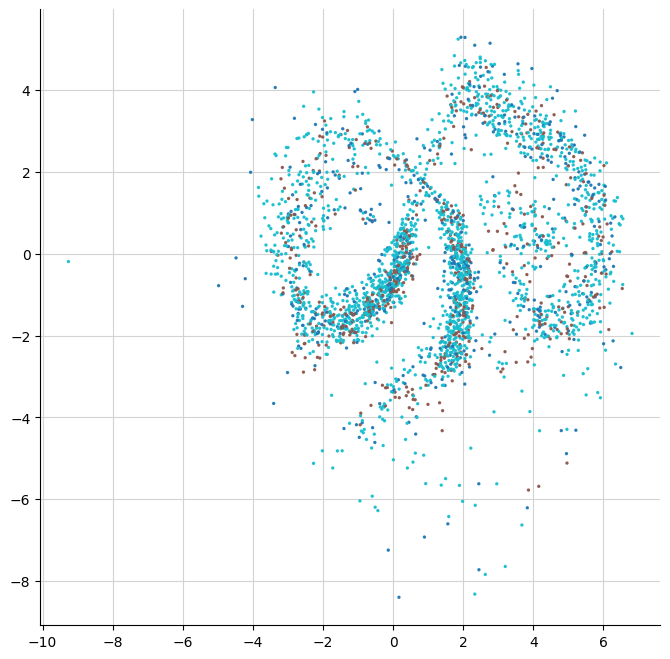

In [ ]:
# Plotting the latent space
plotting(show=True)

In [ ]:
# convert png images to gif
frames = []
imgs = sorted(os.listdir("./ScatterPlots"))

for im in imgs:
    new_frame = Image.open("./ScatterPlots/" + im)
    frames.append(new_frame)
frames[0].save("latentspace.gif", format="GIF",
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

IndexError: list index out of range

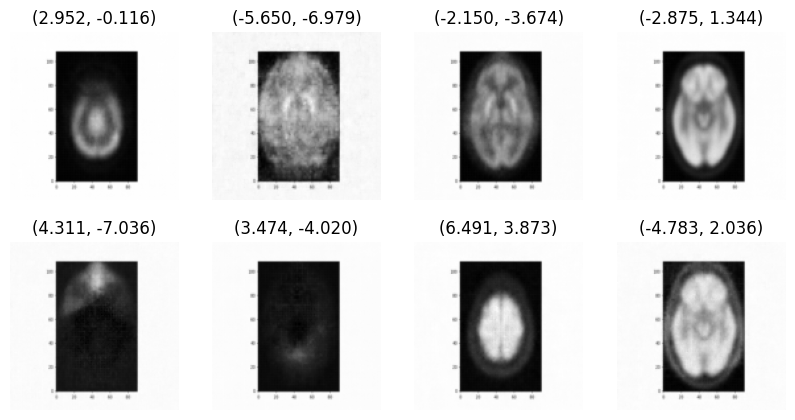

In [ ]:
# randomly sample x and y values
xs = [random.uniform(-6.0, 8.0) for i in range(8)]
ys = [random.uniform(-7.5, 10.0) for i in range(8)]

points = list(zip(xs, ys))
coords = torch.tensor(points).unsqueeze(1).to(DEVICE)

nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))

model.eval()
with torch.no_grad():
    generates = [model.decoder(coord) for coord in coords]

# plot points
idx = 0
for row in range(0, nrows):
    for col in range(0, ncols):
        ax = axes[row, col]
        im = generates[idx].squeeze().detach().cpu()
        ax.imshow(im, cmap="gray")
        ax.axis("off")
        coord = coords[idx].detach().cpu().numpy()[0]
        ax.set_title(f"({coord[0]:.3f}, {coord[1]:.3f})")
        idx += 1
plt.show()
